In [7]:
import pickle
import numpy as np
import pandas as pd

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from numpy.random import seed

from keras.utils import plot_model

from keras import regularizers

from keras.models import model_from_json
import csv
import json

from keras.callbacks import EarlyStopping

X Training set (images) shape: (11829, 28, 28, 1)
X Testset set (images) shape: (5070, 28, 28, 1)
Y Training set (images) shape: (11829, 10)


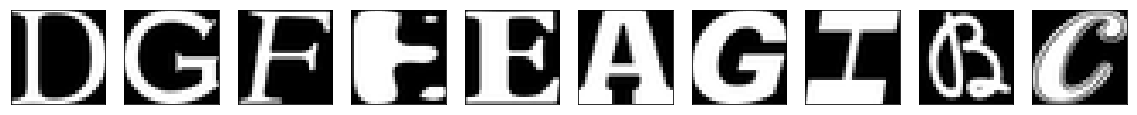

X Training set normalized (images) shape: (11829, 784)
X Testset set normalized (images) shape: (5070, 784)
Y Training set normalized (images) shape: (11829, 20)

Noisy Images


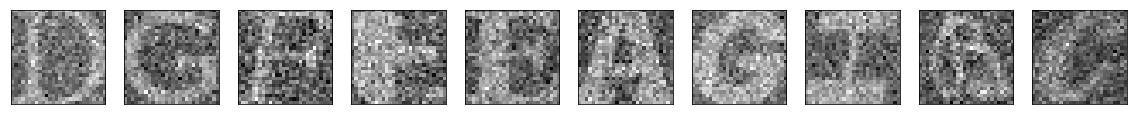

In [3]:
# Load x_test features from file
filename = "./x_test.obj"
with open(filename, 'rb') as file:  
    x_test = pickle.load(file)
    file.close()
    
# Load x_train features from file
filename = "./x_train.obj"
with open(filename, 'rb') as file:  
    x_train = pickle.load(file)
    file.close()
    
# Load y_train label from file
filename = "./y_train.obj"
with open(filename, 'rb') as file:  
    y_train = pickle.load(file)
    file.close()

#See wich data you have
print("X Training set (images) shape: {shape}".format(shape=x_train.shape))
print("X Testset set (images) shape: {shape}".format(shape=x_test.shape))
print("Y Training set (images) shape: {shape}".format(shape=y_train.shape))

#Trasform the y_train to categorical
y_train = to_categorical(y_train)

#Plot the letters
n = 10  # how many letters we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


y_train = y_train.astype('float32') / 255.
y_train = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))

#Create a training and test set with some noise to have a much more robust model
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

y_train_noisy = y_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=y_train.shape)

print("X Training set normalized (images) shape: {shape}".format(shape=x_train.shape))
print("X Testset set normalized (images) shape: {shape}".format(shape=x_test.shape))
print("Y Training set normalized (images) shape: {shape}".format(shape=y_train.shape))

print("\nNoisy Images")

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Build a simple autoencoder
  
Single fully-connected neeural layer as encoder and as decoder

In [11]:

seed(42)

# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input

encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# encoded = Dense(128, activation='relu')(input_img)
# encoded = Dense(64, activation='relu')(encoded)
# encoded = Dense(32, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# decoded = Dense(64, activation='relu')(encoded)
# decoded = Dense(128, activation='relu')(decoded)
# decoded = Dense(784, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

###Create a separate encoder model
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

###Create a Decoder Model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))



In [12]:

#Now train autoencoder to reconstruct the input images
#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'])
#autoencoder.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])



#Launch the autoencoder
history = autoencoder.fit(x_train, x_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_data=(x_test, x_test))



Train on 11829 samples, validate on 5070 samples
Epoch 1/100
11829/11829 [==============================] - 1s 83us/step - loss: 0.6901 - acc: 0.3216 - val_loss: 0.6832 - val_acc: 0.3414
Epoch 2/100
11829/11829 [==============================] - 1s 52us/step - loss: 0.6659 - acc: 0.3662 - val_loss: 0.6450 - val_acc: 0.3832
Epoch 3/100
11829/11829 [==============================] - 1s 49us/step - loss: 0.6318 - acc: 0.3931 - val_loss: 0.6217 - val_acc: 0.4026
Epoch 4/100
11829/11829 [==============================] - 1s 51us/step - loss: 0.6115 - acc: 0.4128 - val_loss: 0.6004 - val_acc: 0.4251
Epoch 5/100
11829/11829 [==============================] - 1s 50us/step - loss: 0.5844 - acc: 0.4377 - val_loss: 0.5670 - val_acc: 0.4493
Epoch 6/100
11829/11829 [==============================] - 1s 50us/step - loss: 0.5476 - acc: 0.4612 - val_loss: 0.5279 - val_acc: 0.4722
Epoch 7/100
11829/11829 [==============================] - 1s 49us/step - loss: 0.5075 - acc: 0.4828 - val_loss: 0.4921 - v

11829/11829 [==============================] - 1s 53us/step - loss: 0.2613 - acc: 0.5779 - val_loss: 0.2585 - val_acc: 0.5772
Epoch 60/100
11829/11829 [==============================] - 1s 49us/step - loss: 0.2598 - acc: 0.5783 - val_loss: 0.2575 - val_acc: 0.5777
Epoch 61/100
11829/11829 [==============================] - 1s 51us/step - loss: 0.2589 - acc: 0.5785 - val_loss: 0.2571 - val_acc: 0.5777
Epoch 62/100
11829/11829 [==============================] - 1s 49us/step - loss: 0.2589 - acc: 0.5785 - val_loss: 0.2629 - val_acc: 0.5765
Epoch 63/100
11829/11829 [==============================] - 1s 49us/step - loss: 0.2584 - acc: 0.5786 - val_loss: 0.2666 - val_acc: 0.5752
Epoch 64/100
11829/11829 [==============================] - 1s 48us/step - loss: 0.2563 - acc: 0.5791 - val_loss: 0.2600 - val_acc: 0.5773
Epoch 65/100
11829/11829 [==============================] - 1s 49us/step - loss: 0.2561 - acc: 0.5792 - val_loss: 0.2572 - val_acc: 0.5776
Epoch 00065: early stopping


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               25872     
Total params: 52,048
Trainable params: 52,048
Non-trainable params: 0
_________________________________________________________________
Keras Autoencoder Keys: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


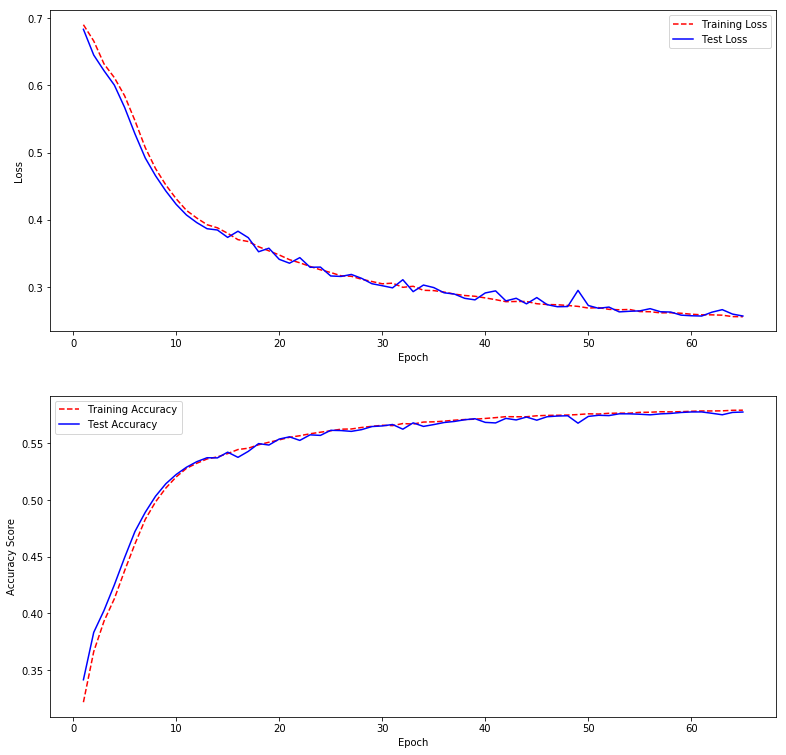

In [15]:
#Visualise the summary of the autoencoder
autoencoder.summary()

# list all data in history
print("Keras Autoencoder Keys: " + str(history.history.keys()))

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
training_acc = history.history['acc']
test_acc = history.history['val_acc']

# Plot the accuracy and cost summaries 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(13,13))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--')
ax1.plot(epoch_count, test_loss, 'b-')
ax1.legend(['Training Loss', 'Test Loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize accuracy history
ax2.plot(epoch_count, training_acc, 'r--')
ax2.plot(epoch_count, test_acc, 'b-')
ax2.legend(['Training Accuracy', 'Test Accuracy'])
ax2.set_ylabel('Accuracy Score')
ax1.set_xlabel('Epoch')

plt.xlabel('Epoch')
plt.show();

# # summarize history for loss
# plt.plot(training_loss)
# plt.plot(test_loss)
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # summarize history for acc
# plt.plot(training_acc)
# plt.plot(test_acc)
# plt.title('model loss')
# plt.ylabel('acc')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


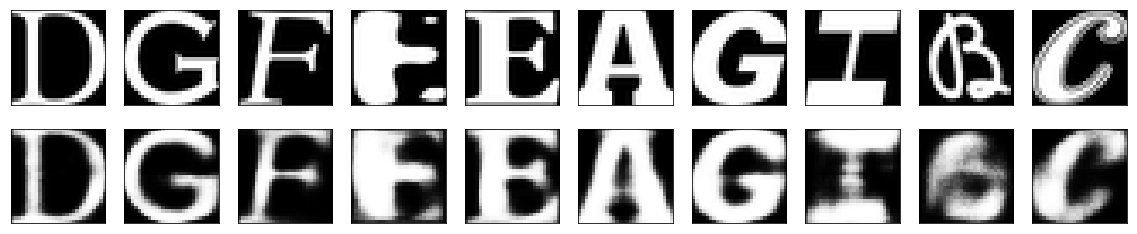

In [29]:
#Try to reconstruct and visualize inputs and the encoded representations
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [46]:
#Save the model

# serialize model to JSON
model_json = autoencoder.to_json()
with open("model-autoencoder.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
autoencoder.save_weights("model-autoencoder.h5")

print("Saved model to disk")


Saved model to disk


## Tests and evaluation

In [45]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")

seed(42)

# num_classes = 20

# #encoded = Flatten()(encoded)
# den = Dense(784, activation='relu')(encoded)
# out = Dense(num_classes, activation='softmax')(den)

# loaded_model = Model(input_img,out)

# for l1,l2 in zip(loaded_model.layers[:3],autoencoder.layers[0:3]):
#     l1.set_weights(l2.get_weights())
# for layer in loaded_model.layers[0:3]:
#     layer.trainable = True

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', # Categorical Cross-entropy
                optimizer='adadelta', 
                metrics=['accuracy'])

classify_train = loaded_model.fit(x_test, x_test, batch_size=64,epochs=5,verbose=1)

predicted_classes = loaded_model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

print(type("Type of Predicted Classes: " + str(predicted_classes)))
print("Ndim: " + str(predicted_classes.ndim))
print("Max: " + str(predicted_classes.max(axis=0)))
print("Min: " + str(predicted_classes.min(axis=0)))
print(predicted_classes)

Loaded model from disk
Epoch 1/5
5070/5070 [==============================] - 1s 214us/step - loss: 0.2302 - acc: 0.5840
Epoch 2/5
5070/5070 [==============================] - 0s 72us/step - loss: 0.2312 - acc: 0.5838
Epoch 3/5
5070/5070 [==============================] - 0s 71us/step - loss: 0.2288 - acc: 0.5843
Epoch 4/5
5070/5070 [==============================] - 0s 74us/step - loss: 0.2291 - acc: 0.5842
Epoch 5/5
5070/5070 [==============================] - 0s 71us/step - loss: 0.2289 - acc: 0.5844
<class 'str'>
Ndim: 1
Max: 748
Min: 0
[ 0 11  7 ... 11 75 10]
